In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import datetime
import pickle
import nltk
import sklearn
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import *
from keras.regularizers import l1,l2, L1L2

In [2]:
seed_value = 273958
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
# load in tweets
with open('../data/pickled_tweets/home_2019_3daysback_nolikecriterion.pkl', 'rb') as f:
    home_2019_tweets = pickle.load(f)
with open('../data/pickled_tweets/away_2019_3daysback_nolikecriterion.pkl', 'rb') as f:
    away_2019_tweets = pickle.load(f)
with open('../data/pickled_tweets/home_2020_3daysback_nolikecriterion.pkl', 'rb') as f:
    home_2020_tweets = pickle.load(f)
with open('../data/pickled_tweets/away_2020_3daysback_nolikecriterion.pkl', 'rb') as f:
    away_2020_tweets = pickle.load(f)

# load in nfl data
s2020 = pd.read_csv('../data/season_data/2020_all_data.csv', index_col=0)
s2019 = pd.read_csv('../data/season_data/2019_all_data.csv', index_col=0)

In [4]:
#Define a list of stopwords to remove.
stopwords = nltk.corpus.stopwords.words("english")

# lemmatize function
def lemmatize(sentence, include_stopwords=False):
    if include_stopwords:
        return [WordNetLemmatizer().lemmatize(word) for word in sentence]
    return [WordNetLemmatizer().lemmatize(word) for word in sentence if word not in stopwords]

# preprocess the tweets - remove punctuation and lemmatize
def preprocess(tweets):
    for i in range(len(tweets)):
        for j in range(len(tweets[i])):
            tweets[i][j] = re.sub('[^a-zA-Z]',' ',tweets[i][j]).split()
            tweets[i][j] = lemmatize(tweets[i][j])

preprocess(home_2019_tweets)
preprocess(away_2019_tweets)
preprocess(home_2020_tweets)
preprocess(away_2020_tweets)

In [5]:
from collections import Counter
def vectorize_list(list_of_tweets, corpus):
    num_tweets = len(list_of_tweets)
    with_repeats = [item for sublist in list_of_tweets for item in sublist]
    counts = dict(Counter(with_repeats))
    to_return = []
    for key in corpus:
        num = np.log(1+counts[key]) if key in counts else 0
        to_return.append(num)
    return to_return

In [6]:
# count unigrams
def count_unigrams(tweet,corpus):
    for word in tweet:
        if word in corpus:
            corpus[word] += 1
        else:
            corpus[word] = 1

In [7]:
#Create the home/away corpus
home_corpus = {}
away_corpus = {}
for tweets in home_2019_tweets:
    for tw in tweets:
        count_unigrams(tw,home_corpus)

for tweets in away_2019_tweets:
    for tw in tweets:
        count_unigrams(tw,away_corpus)

In [8]:
# remove words with <= 2 characters
for key in list(home_corpus.keys()):
    if len(key) <= 2:
        del home_corpus[key]

for key in list(away_corpus.keys()):
    if len(key) <= 2:
        del away_corpus[key]

In [9]:
# get number of tweets for all home and away teams
n_home_tweets = sum([len(game_tweets) for game_tweets in home_2019_tweets])
n_away_tweets = sum([len(game_tweets) for game_tweets in away_2019_tweets])

# get the unigrams that appear in at least 0.1% of home/away tweets
home_top_grams = [word for word in home_corpus if home_corpus[word] > n_home_tweets*0.001]
away_top_grams = [word for word in away_corpus if away_corpus[word] > n_away_tweets*0.001]

In [10]:
# TRAIN SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_2019_tweets]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_2019_tweets]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_train = np.concatenate([home_vecs, away_vecs], axis=1)

# TEST SET
#Create lists of vectors for home, away games
num_h_tweets = [vectorize_list(game, home_top_grams) for game in home_2020_tweets]
num_a_tweets = [vectorize_list(game, away_top_grams) for game in away_2020_tweets]

#Turn into arrays
home_vecs = np.array(num_h_tweets)
away_vecs = np.array(num_a_tweets)

#Concatenate home, away to form input matrix.
X_test = np.concatenate([home_vecs, away_vecs], axis=1)

# TRAIN and TEST outcomes
Y_train = np.array(s2019["Home Win"])
Y_test = np.array(s2020["Home Win"])

In [11]:
# Basic classifiers on full data
lr = LogisticRegression(penalty="none")
lr.fit(X_train, Y_train)
print(lr.score(X_test, Y_test))

lrl1 = LogisticRegressionCV(cv=5,penalty="l1",solver="liblinear",
                            max_iter=1000).fit(X_train, Y_train)
lrl1.fit(X_train, Y_train)
print(lrl1.score(X_test, Y_test))

lrl2 = LogisticRegressionCV(cv=5,penalty="l2",solver="liblinear",
                            max_iter=1000).fit(X_train, Y_train)
lrl2.fit(X_train, Y_train)
print(lrl2.score(X_test, Y_test))

ada = AdaBoostClassifier(n_estimators=200)
ada.fit(X_train, Y_train)
print(ada.score(X_test, Y_test))

rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train, Y_train)
print(rf.score(X_test, Y_test))

gnb = GaussianNB().fit(X_train, Y_train)
gnb.fit(X_train, Y_train)
print(gnb.score(X_test, Y_test))

0.578125
0.58203125
0.625
0.51953125
0.55859375
0.5703125


In [12]:
reg=1e-5
model = Sequential()
#model.add(Dense(1024, activation='tanh', kernel_regularizer=L1L2(reg), input_dim=X_train.shape[1]))
#model.add(Dropout(.1))
#model.add(Dense(512, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(256, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
#model.add(Dense(128, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(64, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, verbose=True)
model.evaluate(X_test, Y_test)

Epoch 1/20
8/8 [==============================] - 0s 3ms/step - loss: 2.2759 - accuracy: 0.4258
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.4763
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.9141 - accuracy: 0.4894
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8531 - accuracy: 0.5539
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8679 - accuracy: 0.5088
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8680 - accuracy: 0.4990
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8562 - accuracy: 0.5489
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8539 - accuracy: 0.5325
Epoch 9/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8538 - accuracy: 0.6232
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.8468 - accuracy: 0.5291
Epoch 11/20
8/8 [======================

[0.8177796602249146, 0.578125]

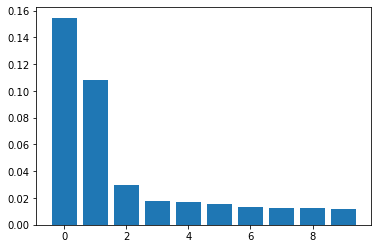

In [13]:
# Use PCA to reduce dimensions of X to n components
n = 10
pca = sklearn.decomposition.PCA(n_components=n)
pca.fit(X_train)
plt.bar(x=range(n),height=pca.explained_variance_ratio_)
reduced_X_train = pca.transform(X_train)
reduced_X_test = pca.transform(X_test)

In [14]:
# Basic classifiers on reduced data
lr = LogisticRegression()
lr.fit(reduced_X_train, Y_train)
print(lr.score(reduced_X_test, Y_test))

lrl1 = LogisticRegressionCV(cv=5,penalty="l1",solver="liblinear",
                            max_iter=1000).fit(reduced_X_train, Y_train)
lrl1.fit(reduced_X_train, Y_train)
print(lrl1.score(reduced_X_test, Y_test))

lrl2 = LogisticRegressionCV(cv=5,penalty="l2",solver="liblinear",
                            max_iter=1000).fit(reduced_X_train, Y_train)
lrl2.fit(reduced_X_train, Y_train)
print(lrl2.score(reduced_X_test, Y_test))

ada = AdaBoostClassifier(n_estimators=200)
ada.fit(reduced_X_train, Y_train)
print(ada.score(reduced_X_test, Y_test))

rf = RandomForestClassifier(n_estimators=400)
rf.fit(reduced_X_train, Y_train)
print(rf.score(reduced_X_test, Y_test))

gnb = GaussianNB().fit(reduced_X_train, Y_train)
gnb.fit(reduced_X_train, Y_train)
print(gnb.score(reduced_X_test, Y_test))

0.60546875
0.58984375
0.609375
0.546875
0.61328125
0.52734375


In [15]:
reg=1e-5
model = Sequential()
#model.add(Dense(1024, activation='tanh', kernel_regularizer=L1L2(reg), input_dim=reduced_X_train.shape[1]))
#model.add(Dropout(.1))
#model.add(Dense(512, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(256, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
#model.add(Dense(128, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(64, activation='tanh',kernel_regularizer=L1L2(reg)))
#model.add(Dropout(.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.fit(reduced_X_train, Y_train, epochs=20, verbose=True)
model.evaluate(reduced_X_test, Y_test)

Epoch 1/20
8/8 [==============================] - 0s 1ms/step - loss: 0.7532 - accuracy: 0.5846
Epoch 2/20
8/8 [==============================] - 0s 879us/step - loss: 0.6389 - accuracy: 0.6085
Epoch 3/20
8/8 [==============================] - 0s 859us/step - loss: 0.6121 - accuracy: 0.6889
Epoch 4/20
8/8 [==============================] - 0s 854us/step - loss: 0.6029 - accuracy: 0.6467
Epoch 5/20
8/8 [==============================] - 0s 863us/step - loss: 0.5531 - accuracy: 0.7268
Epoch 6/20
8/8 [==============================] - 0s 866us/step - loss: 0.5138 - accuracy: 0.7649
Epoch 7/20
8/8 [==============================] - 0s 810us/step - loss: 0.5136 - accuracy: 0.7888
Epoch 8/20
8/8 [==============================] - 0s 878us/step - loss: 0.4881 - accuracy: 0.8176
Epoch 9/20
8/8 [==============================] - 0s 834us/step - loss: 0.4439 - accuracy: 0.8254
Epoch 10/20
8/8 [==============================] - 0s 832us/step - loss: 0.4454 - accuracy: 0.8393
Epoch 11/20
8/8 [====

[0.7698532938957214, 0.546875]